In [1]:
import sys
import argparse

import numpy as np
from scipy.misc import imread, imresize

import matplotlib.pyplot as plt
%matplotlib inline
import random

%load_ext autoreload
%autoreload 2
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import caffe
model_def = '/home/karpathy/caffe3/models/linear_imagenet/deploy.prototxt'
model = '/home/karpathy/caffe3/models/linear_imagenet/linear_train_iter_120000.caffemodel'
net = caffe.Net(model_def, model, caffe.TEST)
w = net.layers[0].blobs[0].data.squeeze()
b = net.layers[0].blobs[1].data.squeeze()

print(w.shape)
print (b.shape)

# visualize goldfish filter
rw = np.reshape(w[1], (3,56,56)).copy() # take a filter and reshape it
rw = np.transpose(rw, (1, 2, 0)) # make channels dim last
rw = rw[:,:,(2,1,0)] # RGB -> BGR. Sigh, Caffe...
rw -= rw.min() # normalize to uint8 [0,255]
rw /= rw.max()
rw *= 255
plt.imshow(rw.astype('uint8'))

ImportError: No module named 'caffe'

In [6]:
# load ILSVRC synset names
ws = open('../data/ilsvrc12/synset_words.txt').read().splitlines()
wsb = []
for s in ws:
    f0 = s.find(' ')
    f1 = s.find(',')
    if f1 == -1: f1 = len(s)
    wsb.append(s[f0+1:f1])

In [8]:
def read_image(path):
    im = imread(path)
    if len(im.shape) == 2:
        im = np.tile(im[:,:,np.newaxis], (1,1,3)) # grayscale to RGB if needed
    return im

szh,szw = (56,56)
im = read_image('images/cat.jpg')
imr = imresize(im, (szh, szw)).astype(np.float32)

fooling to:
n01443537 goldfish, Carassius auratus
-----
0.0101035 n02281787 lycaenid, lycaenid butterfly
0.00895853 n02119789 kit fox, Vulpes macrotis
0.00859 n02119022 red fox, Vulpes vulpes
0.00726468 n07714571 head cabbage
0.00710512 n02326432 hare
---
0.0533325 n01443537 goldfish, Carassius auratus
0.013886 n02119022 red fox, Vulpes vulpes
0.0112345 n02115913 dhole, Cuon alpinus
0.0105261 n02119789 kit fox, Vulpes macrotis
0.00998585 n02281406 sulphur butterfly, sulfur butterfly


(-0.5, 55.5, 55.5, -0.5)

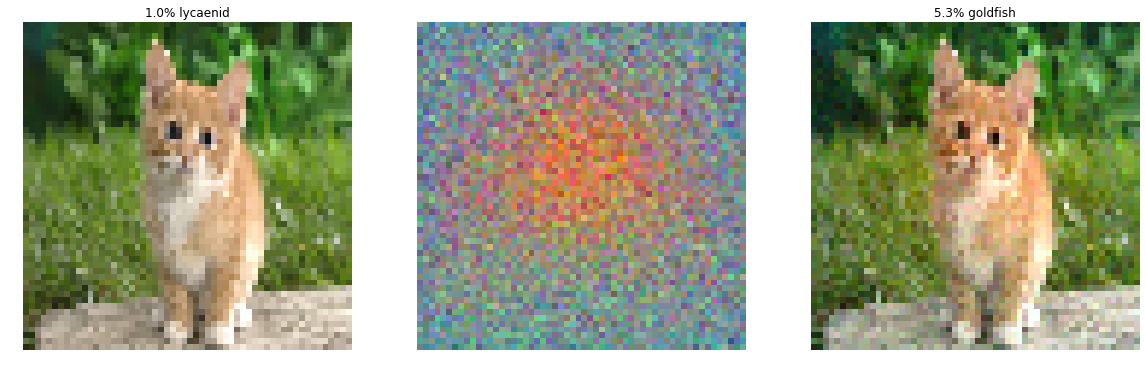

In [10]:
def forward_resized_float_image(imr):
    # forward image through
    data = imr[:,:,(2,1,0)] # RGB -> BGR
    data -= np.array([104, 117, 123]) # subtract fixed mean
    data = np.transpose(data, (2, 0, 1))
    batch = np.zeros((1, 3, data.shape[1], data.shape[2]))
    batch[0] = data
    net.blobs['data'].reshape(*(batch.shape))
    feat = net.forward(data=batch, blobs=['prob', 'fc8'])
    return feat['fc8'].flatten(), feat['prob'].flatten()

foolix = 1
print 'fooling to:'
print ws[foolix]
print '-----'

f,p = forward_resized_float_image(imr)
ix = np.argsort(-f)
for i in ix[:5]:
    print p[i], ws[i]

plt.figure(figsize = (20, 8))
plt.subplot(1,3,1)
plt.imshow(imr.astype('uint8'))
plt.axis('off')
plt.title('%.1f%% %s' % (p[ix[0]]*100, wsb[ix[0]]))

print '---'
imr2 = imr.copy()
wc = np.reshape(w[foolix], (3,56,56)).copy()
wc = np.transpose(wc, (1,2,0))
wc = wc[:,:,(2,1,0)]
imr2 += 300000.0 * wc

f,p = forward_resized_float_image(imr2)

ix = np.argsort(-f)
for i in ix[:5]:
    print p[i], ws[i]

plt.subplot(1,3,2)
wi = wc - np.min(wc)
wi /= wi.max()
wi *= 255
plt.imshow(wi.astype('uint8'))
plt.axis('off')

plt.subplot(1,3,3)
imr2i = imr2.copy()
imr2i[imr2i < 0] = 0
imr2i[imr2i >= 255] = 255
plt.imshow(imr2i.astype('uint8'))
plt.title('%.1f%% %s' % (p[ix[0]]*100, wsb[ix[0]]))
plt.axis('off')